In [53]:
# analyze the session logs from the IPE user study
import numpy as np
import codecs
import re
import json
import os
import copy

from collections import defaultdict, Counter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
participant_project_settings = {
    'P38': {
        'BASIC': 1,
        'QE': 2,
        'CD': 3,
        'IPE': 4
    },
    'P92': {
        'BASIC': 2,
        'QE': 3,
        'CD': 4,
        'IPE': 1
    }
    'P93': {
        'BASIC': 3,
        'QE': 4,
        'CD': 1,
        'IPE': 2 
    }
    'P94': {
        'BASIC': 4,
        'QE': 1,
        'CD': 2,
        'IPE': 3 
    }
    'P81': {
        'BASIC': 1,
        'QE': 2,
        'CD': 4,
        'IPE': 3
    }
}

In [ ]:
LOG_DIR='/home/chris/Desktop/Dropbox/projects/handycat_interactive_pe/user_study_logs'

In [62]:

# Now make a map from participants to all of thier log files 
# Because of the way we collect logs, projects may be duplicated across multiple logfiles for a participant
def logdir_to_participant_log_map(logdir):
    task_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
    participant_logfiles = defaultdict(list)
    for participant_id in os.listdir(logdir):
        print('id: {}'.format(participant_id))
        for item in os.listdir(os.path.join(logdir, participant_id)):
            if item.endswith('.json'):
                participant_logfiles[participant_id].append(os.path.join(logdir, participant_id, item))
    
    # parse each logfile to extract its project objects
    nested_dict = lambda: defaultdict(nested_dict)
    participant_logs = nested_dict()
    for p_id, logfiles in participant_logfiles.items():
        print('parsing logs for {}'.format(p_id))
        log_objs = [json.loads(open(f).read()) for f in logfiles]
        # now we need to deduplicate any projects that appear in the logs multiple times
        for log_obj in log_objs:
            for docname, log_entries in log_obj['document'].items():
                # extract the setting from the name
                # names are: `<setting>-Task-<id-letter>`
                project_setting, _, project_identifier = docname.split('-')
                project_id = task_map[project_identifier]
                # sanity: just assert that any duplicate entries have the same number of entries
                if p_id in participant_logs:
                    if project_setting in participant_logs[p_id]:
                        assert len(json.dumps(participant_logs[p_id][project_setting]['segments'])) \
                        == len(json.dumps(log_entries['segments']))
                # note we just overwrite because duplicates are identical anyway
                participant_logs[p_id][project_setting]['segments'] = log_entries['segments']
                participant_logs[p_id][project_setting]['project_id'] = project_id

    # assert all project types exist for all participants
    for p_id, projects in participant_logs.items():
        assert len(projects) == 4
        assert set(['BASIC', 'QE', 'CD', 'IPE']) == set(projects.keys())
       
    return participant_logs
 

In [63]:
logs = logdir_to_participant_log_map(LOG_DIR)

id: P93
id: P81
id: P38
id: P94
id: P92
parsing logs for P93
parsing logs for P81
parsing logs for P38
parsing logs for P94
parsing logs for P92


In [65]:
logs['P38']['BASIC']['segments']

{'0': [{'action': 'change-segment',
   'data': {'currentValue': 'Sie können auf diese Verknüpfungen, um die verknüpften Einträge anzuzeigen.',
    'segmentId': 0},
   'project': {'_id': '5a61bd327b92872a3118a52f', 'name': 'BASIC-Task-A'},
   'time': 1516356538374,
   'user': {'_id': '5a61bd157b92872a3118a52b', 'name': 'P38'}},
  {'action': 'default',
   'data': {'newTarget': '    Sie können auf diese Verknüpfungen, um die verknüpften Einträge anzuzeigen.   ',
    'originalTarget': 'Sie können auf diese Verknüpfungen, um die verknüpften Einträge anzuzeigen.'},
   'project': {'_id': '5a61bd327b92872a3118a52f', 'name': 'BASIC-Task-A'},
   'time': 1516356538415,
   'user': {'_id': '5a61bd157b92872a3118a52b', 'name': 'P38'}},
  {'action': 'segment-complete',
   'data': {'newValue': 'Sie können auf diese Verknüpfungen, um die verknüpften Einträge anzuzeigen.',
    'previousValue': 'Sie können auf diese Verknüpfungen, um die verknüpften Einträge anzuzeigen.',
    'segmentId': 0},
   'project'

In [57]:
def flatten_segment_logs(segment_logs, action_namespace=None):
    flat_actions = []
    for segment_log in segment_logs:
        for seg_id, actions in segment_log.items():
            if action_namespace is not None:
                actions = [a for a in actions if a['action'].split('.')[0] == action_namespace]
            flat_actions.extend(actions)
    return flat_actions


In [58]:
def edit_actions_by_type(segment_logs):
    ipe_actions = flatten_segment_logs(segment_logs, action_namespace='ipe')
    action_counts = Counter()
    action_counts.update([a['action'].split('.')[1] for a in ipe_actions])
    return action_counts
    

In [92]:
def edit_actions_by_setting(user_logs):
    ipe_actions = {}
    for setting, setting_data in user_logs.items():
        print(setting)
        ipe_actions[setting] = Counter([a['action'].split('.')[1]
                                        for a in flatten_segment_logs([setting_data['segments']], 
                                                                      action_namespace='ipe')]) 
    return ipe_actions


In [93]:
user_action_counts = {p_id: edit_actions_by_type([data['segments'] for setting, data in d.items()])
                      for p_id, d in logs.items()}

In [94]:
user_actions_by_setting = {p_id: edit_actions_by_setting(data) for p_id, data in logs.items()}

BASIC
QE
CD
IPE
BASIC
QE
CD
IPE
BASIC
QE
CD
IPE
BASIC
QE
CD
IPE
QE
BASIC
CD
IPE


In [95]:
# VISUALIZATIONS

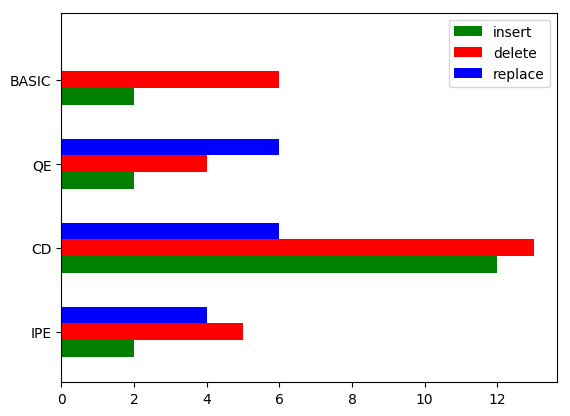

In [124]:
import matplotlib.pyplot as plt
import numpy as np


def barplot_action_types(actions_by_setting):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    settings = ['IPE', 'CD', 'QE', 'BASIC']
    action_types = ['insert', 'delete', 'replace']
    action_colors = {
        'insert': 'green',
        'delete': 'red',
        'replace': 'blue'
    }
    
    ind = np.arange(len(actions_by_setting))
    width = 0.2
    
    bar_groups = defaultdict(list)
    # TODO: group label is setting
    for setting in settings:
        action_counts = actions_by_setting[setting]
        for action in action_types:
            if action in action_counts:
                bar_groups[action].append(action_counts[action])
            else:
                bar_groups[action].append(0)
    
    # TODO: colored legend by action type
    for offset, (action, counts) in enumerate(bar_groups.items()):
        ax.barh(ind + (width*offset), counts, width, 
                color=action_colors[action], 
                label=action)
    
    # Add the axis labels
    #ax.set_ylabel("Editing Time (seconds)")
    #ax.set_xlabel("Sentence Id (sorted by increasing length)")
    ax.set(yticks=ind+(1*width),
           yticklabels=settings,
           ylim=[3*width - 1, len(actions_by_setting)])
    
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper right')
    ax.legend()

barplot_action_types(user_actions_by_setting['P81'])
plt.show()


In [4]:

%matplotlib inline

# Now make bar chart with X axis sorted by sentence length
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator as o

import numpy as np
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

# print(
#     json.dumps(
#       sorted(avg_time_per_autocomplete_type_with_sentence_length['dataset_1'].items(), key=lambda x: x[1]['length']),
#       indent=2))

fig = plt.figure()
ax = fig.add_subplot(111)
# fig.tight_layout()
plt.autoscale(tight=True)
plt.margins(x=0.01, y=0.04)

def barplot(ax, dpoints, cats, lens):
    '''
    Create a barchart for data across different categories with
    multiple conditions for each category.
    
    @param ax: The plotting axes from matplotlib.
    @param dpoints: The data set as an (n, 3) numpy array
    '''
    
    # sort categories by sentence len 
    # Aggregate the conditions and the categories according to their
    # mean values
    conditions = [(c, np.mean(dpoints[dpoints[:,0] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,0])]
#     categories = [(c, np.mean(dpoints[dpoints[:,1] == c][:,2].astype(float))) 
#                   for c in np.unique(dpoints[:,1])]
    
    # sort the conditions, categories and data so that the bars in
    # the plot will be ordered by category and condition
    
    # sort conditions by sentence length
    conditions = [c[0] for c in sorted(conditions, key=o.itemgetter(1))]
    x_axis_cats = [c[0] for c in sorted(zip(cats, lens), key=lambda x: x[1])]
#     categories = [c[0][0] for c in sorted(zip(categories, sentence_lens), key=o.itemgetter(1))]
    
    dpoints = np.array(sorted(dpoints, key=lambda x: x_axis_cats.index(x[1])))

    # the space between each set of bars
    space = 0.3
    n = len(conditions)
    width = (1 - space) / (len(conditions))
    
    # Create a set of bars at each position
    for i,cond in enumerate(conditions):
        indeces = range(1, len(x_axis_cats)+1)
        vals = dpoints[dpoints[:,0] == cond][:,2].astype(np.float)
        pos = [j - (1 - space) / 2. + i * width for j in indeces]
        ax.bar(pos, vals, width=width, label=cond, 
               color=cm.Accent(float(i) / n))
    
    # Set the x-axis tick labels to be equal to the categories
    ax.set_xticks(indeces)
    ax.set_xticklabels(x_axis_cats)
#     ax.set_xticklabels(sorted(lens))

    plt.setp(plt.xticks()[1], rotation=90)
    
    # Add the axis labels
    ax.set_ylabel("Editing Time (seconds)")
    ax.set_xlabel("Sentence Id (sorted by increasing length)")
    
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper left')

    return x_axis_cats

        
x_axis_labels = barplot(ax, dpoints, categories, sentence_lens)
# savefig('barchart_3.png')
# width = 9
# height = 6
# plt.figure(figsize=(width, height))
plt.show()